<a href="https://colab.research.google.com/github/tanvircr7/meh/blob/master/ViT_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 32.61 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**GET DATA**

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

**DATASETS == DATALOADERS**

In [7]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE,
)
len(train_dataloader), test_dataloader, class_names

(8,
 ['pizza', 'steak', 'sushi'])

In [9]:
# visualize single image
img, label = next(iter(train_dataloader))
# Display the image
# plt.imshow(img) # ERROR: C H W vs H W C
# plt.axis('off')  # Optional: Turn off axes for better visualization
# plt.show()
img[0], label[0]

(tensor([[[0.3137, 0.3216, 0.3451,  ..., 0.0667, 0.0667, 0.0627],
          [0.3294, 0.3294, 0.3412,  ..., 0.0588, 0.0588, 0.0667],
          [0.3176, 0.3255, 0.3373,  ..., 0.0549, 0.0510, 0.0549],
          ...,
          [0.2784, 0.2941, 0.3059,  ..., 0.7333, 0.6353, 0.4745],
          [0.2824, 0.2902, 0.2941,  ..., 0.5647, 0.4353, 0.3961],
          [0.2902, 0.2941, 0.3020,  ..., 0.3725, 0.4235, 0.4745]],
 
         [[0.4157, 0.4392, 0.4902,  ..., 0.0902, 0.0902, 0.0863],
          [0.4235, 0.4471, 0.4863,  ..., 0.0824, 0.0784, 0.0902],
          [0.4157, 0.4314, 0.4706,  ..., 0.0824, 0.0745, 0.0784],
          ...,
          [0.1961, 0.2000, 0.2000,  ..., 0.6667, 0.5255, 0.3529],
          [0.1843, 0.1922, 0.1922,  ..., 0.4392, 0.2824, 0.2392],
          [0.1882, 0.2000, 0.2078,  ..., 0.2196, 0.2667, 0.3294]],
 
         [[0.7686, 0.8078, 0.8784,  ..., 0.1882, 0.1922, 0.1882],
          [0.7765, 0.8118, 0.8706,  ..., 0.1922, 0.1922, 0.2000],
          [0.7686, 0.8000, 0.8549,  ...,

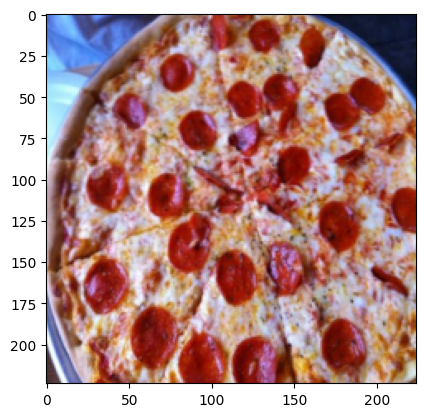

In [10]:
import torchvision.transforms as T

# Assuming img is a tensor in the form [C, H, W] (channel-first)
# Convert it to a NumPy array in [H, W, C] format
img_np = T.ToPILImage()(img[0]).convert("RGB")
# img_np = img[0].permute(1,2,0)
plt.imshow(img_np)

# **4. EQUATION 1**

In [11]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [12]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


# 4.2 Turning a single image into patches

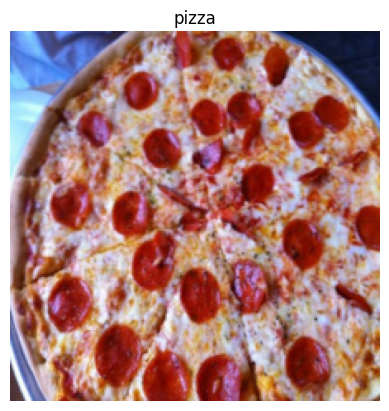

In [13]:
# View single img
import matplotlib.pyplot as plt
image = img[0]
label = label[0]
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

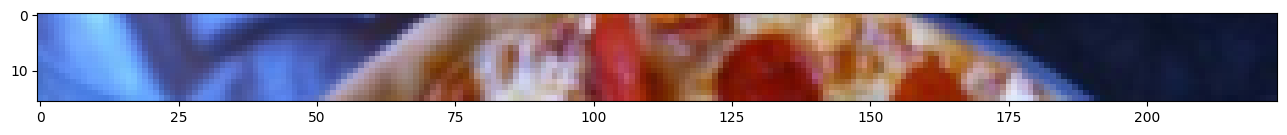

In [14]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels
0: 0
1: 16
2: 32
3: 48
4: 64
5: 80
6: 96
7: 112
8: 128
9: 144
10: 160
11: 176
12: 192
13: 208


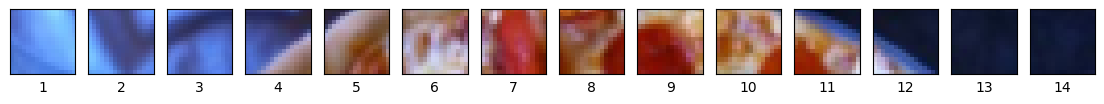

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    print(f"{i}: {patch}")
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


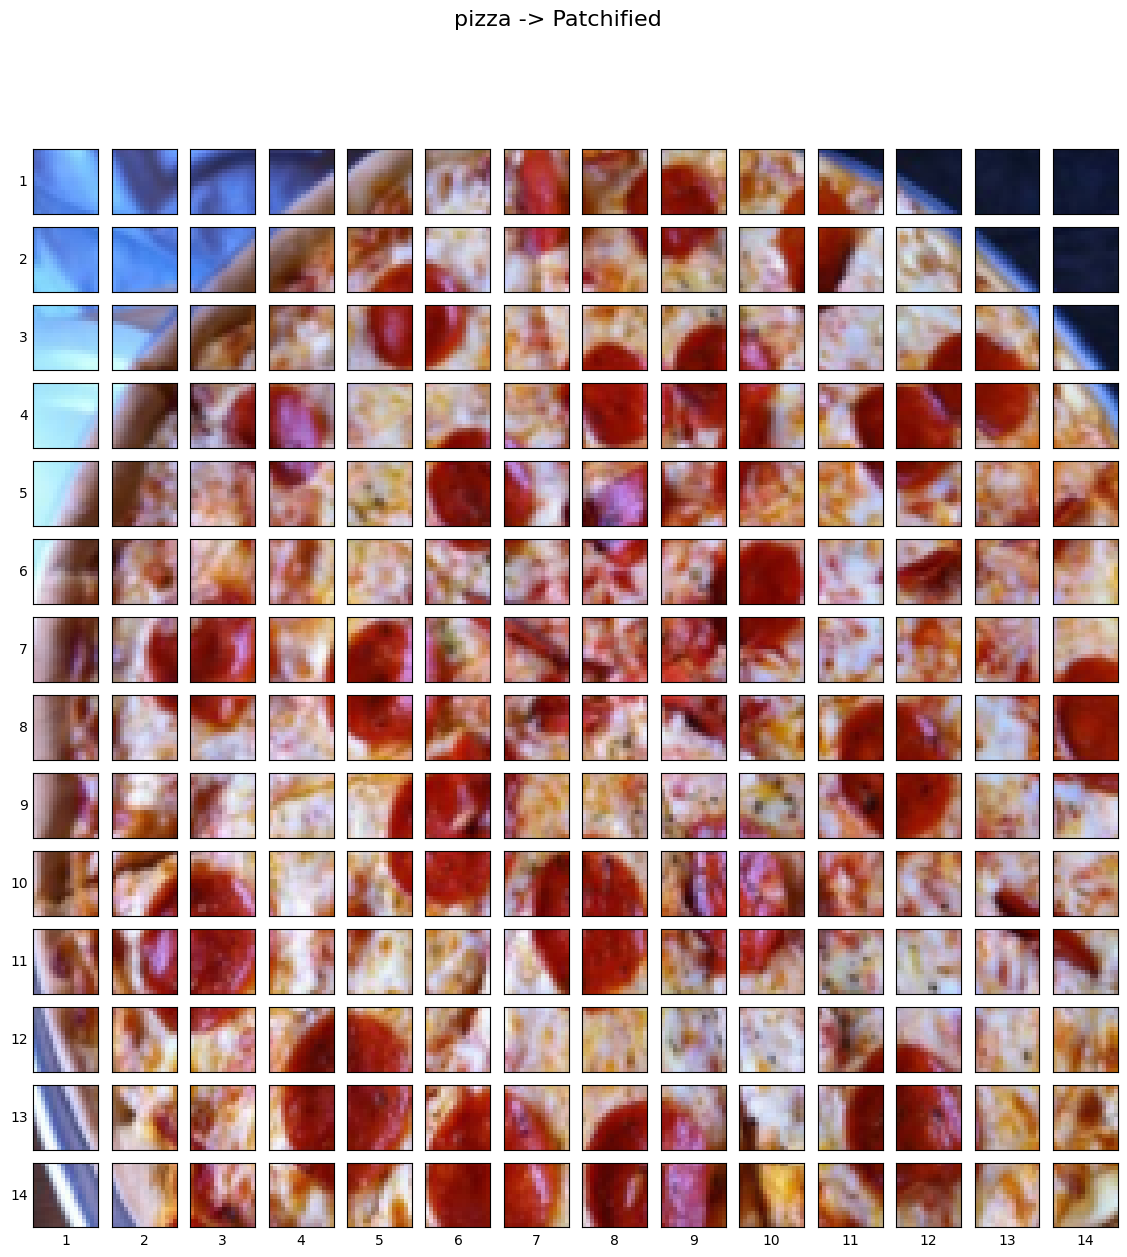

In [16]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

# **4.3 Conv2d**

In [17]:
from torch import nn
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

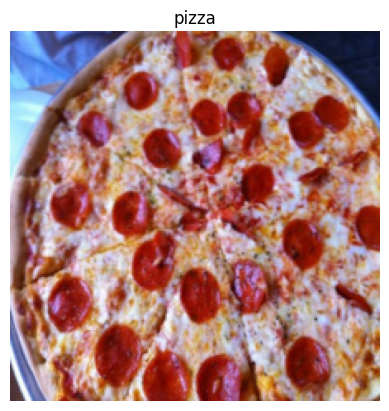

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
output_conv_image = conv2d(image.unsqueeze(dim=0))
print(f"Output shape: {output_conv_image.shape}")
# print(output.shape)
# output

Output shape: torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [282, 475, 439, 572, 99]


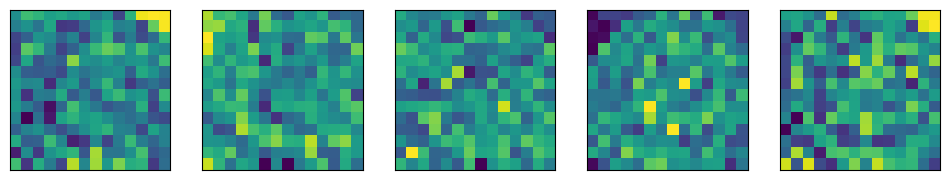

In [20]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = output_conv_image[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

# **4.4 Flattening**

In [21]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


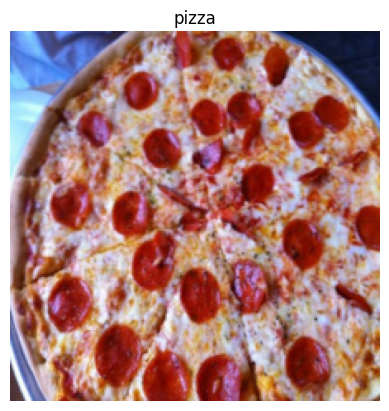

In [22]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [23]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


**We've now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.**

How about we visualize one of the flattened feature maps?

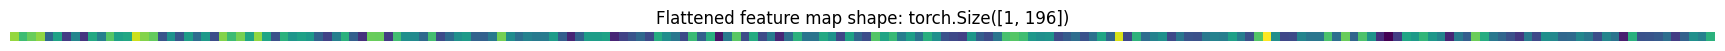

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [25]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.1491,  0.0599,  0.1084,  0.1444, -0.1473, -0.0038, -0.2388, -0.0775,
          -0.2537,  0.0086, -0.0891,  0.0893, -0.0097,  0.0068,  0.1966,  0.1324,
           0.1046, -0.1914, -0.0448, -0.1861, -0.0186, -0.1376, -0.0261, -0.2057,
           0.1326,  0.0570,  0.1224,  0.0016,  0.1477,  0.0004, -0.1987,  0.0312,
          -0.0369, -0.0094, -0.0271, -0.1607, -0.2286, -0.0917,  0.0310, -0.1635,
          -0.2633,  0.1087,  0.1058, -0.2430,  0.0645, -0.0518, -0.0639, -0.1435,
           0.0680, -0.2111, -0.1385, -0.0502, -0.0238, -0.1571, -0.1641, -0.1021,
           0.1201, -0.0595, -0.1298, -0.0847, -0.1056, -0.1001, -0.0202, -0.1700,
          -0.2824, -0.1601, -0.0171, -0.0180, -0.0066, -0.2843, -0.2283, -0.1908,
          -0.1463, -0.2130,  0.0187, -0.0573, -0.1119, -0.2110,  0.0548, -0.1612,
           0.0258, -0.3107, -0.1052,  0.0921, -0.2075,  0.0171, -0.2096, -0.1054,
          -0.2801, -0.1354,  0.0320, -0.1156, -0.1185,  0.0090, -0.0460, -0.2197,
          -0.005

# **4.5 Turning the ViT patch embedding layer into a PyTorch module**

Specifically we'll:

1.   Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2.   Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using nn.Conv2d() (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture
(${N \times\left(P^{2} \cdot C\right)}$)






In [46]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
    super().__init__()
    self.patch_size = patch_size
    self.conv2d_layer = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, input):
    # Create assertion to check that inputs are the correct shape
    image_resolution = input.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    image = input
    print(f"[INFO] Image shape {image.shape}")
    temp = self.conv2d_layer(image.unsqueeze(0))
    temp2 = self.flatten(temp)
    print(f"[INFO] final shape {temp2.shape}")
    temp3 = temp2.permute(0,2,1)
    return temp3

In [47]:
model = PatchEmbedding()
model

PatchEmbedding(
  (conv2d_layer): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=3)
)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
------ with Model --------
[INFO] Image shape torch.Size([3, 224, 224])
[INFO] final shape torch.Size([1, 768, 196])
Flattened image feature map shape: torch.Size([1, 196, 768])


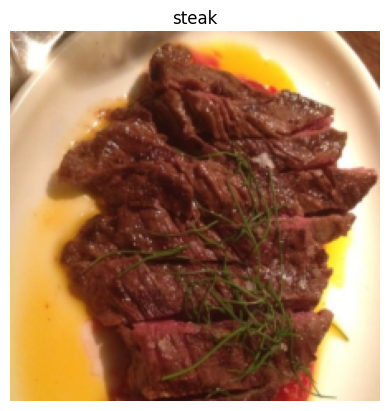

In [48]:
img, label = next(iter(train_dataloader))

# View single img
import matplotlib.pyplot as plt

image = img[1]
label = label[1]
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


print(f"------ with Model --------")

# 2. Turn image into feature maps
image_out_of_model = model(image)
print(f"Flattened image feature map shape: {image_out_of_model.shape}")

In [50]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
[INFO] Image shape torch.Size([3, 224, 224])
[INFO] final shape torch.Size([1, 768, 196])
Output patch embedding shape: torch.Size([1, 196, 768])


In [53]:
# Create random input sizes
# random_input_image = (1, 3, 224, 224)
random_input_image = (3, 224, 224)
# random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size
random_input_image_error = (3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Image shape torch.Size([3, 224, 224])
[INFO] final shape torch.Size([1, 768, 196])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [3, 224, 224]        [1, 196, 768]        --                   True
├─Conv2d (conv2d_layer)                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

# **4.6 Creating the class token embedding**

In [54]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9599,  0.1531, -0.2840,  ...,  0.5722, -0.2370,  0.1698],
         [-0.8150,  0.1655, -0.1690,  ...,  0.5377, -0.2432,  0.3794],
         [-0.7171,  0.1810, -0.1067,  ...,  0.4436, -0.2453,  0.2222],
         ...,
         [-0.8770,  0.4140, -0.1326,  ...,  0.5113, -0.2180,  0.0816],
         [-1.0082,  0.2270, -0.2327,  ...,  0.7228, -0.4759,  0.3487],
         [-0.8984,  0.1713, -0.2165,  ...,  0.6594, -0.4503,  0.3611]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]
